# SENTINEL 2 LEVEL 2A DATA ACQUISITION

**Purpose** : 
> This notebook shows how to download sentinel 2 level 2A processing satellite imagery.\
> To run the this notebook, you need to create an account at [Copernicus Open Access Hub]

<hr/> 

## Import requires packages

In [1]:
# Import necessary packages
import os 
import cv2
from datetime import date
import json
import itertools
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sentinelhub import pixel_to_utm, utm_to_pixel
import utm
import pandas as pd
from shapely.geometry import box
from rasterio.mask import mask
from folium import Map, GeoJson, Figure
import earthpy.plot as ep
import rioxarray as rxr

<hr/> 

## Step 1 : Set the credentials

> We first need to create an account at [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home)\
> Then create the file **sentinel_api_credentials.json** using the following template.

```
{
  "username": "username",
  "password": "XXXXXXXXXX",
}
```

<hr/> 

## Step 2 : Choose the Area of Interest (AOI)

### Load our OAI in a geopandas data frame

In [2]:
#Set the path to data
root_dir = r"/home/duplex/Gitlab/Satellite_Data_Analysis/data/aoi"
aoi_path = os.path.join(root_dir, 'fkkl_rwy.geojson')
# Load the site boundaries into a geopandas dataframe 
gdf = gpd.read_file(aoi_path )
# Set the crs to EPSG 4326 in case of our data is in aonther crs
gdf  = gdf.to_crs("EPSG:4326")
# Get AOI bounds
bbox_aoi = gdf.geometry.total_bounds
# Get AOI centroid for plotting with folium
centroid_aoi = [box(*bbox_aoi).centroid.x, box(*bbox_aoi).centroid.y]
print(centroid_aoi)

[14.257341626582337, 10.45138193190768]


### Plot the gridded AOI

In [7]:
m = Map(tiles="OpenStreetMap",
        control_scale=True,
        location = [centroid_aoi[1], centroid_aoi[0]],
        zoom_start = 10,
        max_zoom = 20,
        min_zoom =6,
        width = '100%',
        height = '100%',
        zoom_control=False )
GeoJson(gdf).add_to(m)
Figure(width=500, height=300).add_child(m)

<hr/> 

## Step 3 : Access sentinel 2 Level 2A data

In [8]:
#Open the file containing the credentials username and password
with open(r"/media/duplex/COMMUN/geoml/fkkl_eo_fire_project/secrets/sentinel_api_credentials.json", "r") as infile:
    credentials = json.load(infile)    
#Set the API
api = SentinelAPI(credentials["username"], credentials["password"], "https://scihub.copernicus.eu/dhus")
# set the boundary of our AOI
shape = geojson_to_wkt(read_geojson(aoi_path))
#configure parameters for download
images = api.query(
    #the aoi
    shape,
    #The start and end date
    date=(date(2022, 2, 18), date(2022,3, 18)),
    #The product type
    platformname="Sentinel-2",
    #The processing level
    processinglevel = "Level-2A",
    #Set the cloud cover percentage between 0 and 30%
    cloudcoverpercentage=(0, 30)
)

<hr/> 

## Step 4 : Check the data available and cloud cover percentage

In [9]:
images_df = api.to_dataframe(images)

key_columns = ["platformserialidentifier", "processinglevel", "cloudcoverpercentage", 
               "vegetationpercentage", "beginposition"]
images_df[key_columns].head(5)

,platformserialidentifier,processinglevel,cloudcoverpercentage,vegetationpercentage,beginposition
05f8ca01-905b-4d5e-b46f-af1713443ccb,Sentinel-2A,Level-2A,1.644049,0.000000,2022-03-14 09:20:31.024
227ea123-34fb-4e0c-b465-0a4b7e549d33,Sentinel-2A,Level-2A,14.017169,0.186914,2022-03-04 09:20:31.024
901faccd-9daa-47cf-aaea-b137dad27bb5,Sentinel-2B,Level-2A,0.038318,0.128009,2022-02-27 09:20:29.024
ad7e8814-e30b-4f48-8aba-e5a5d2131882,Sentinel-2A,Level-2A,0.017525,0.233274,2022-02-22 09:20:31.024


<hr/> 

## Step 5 : Doanload images

> Select an **uuid** from the **images_dfindex** with less cloud cover

In [ ]:
uuid = "ad7e8814-e30b-4f48-8aba-e5a5d2131882"
api.download(uuid)

<hr/> 

## Step 6 - Extract Blue, Green, Red and Near Infrared bands

> Between those two steps, you should unzip the file and copy it to **data** folder.

> We will extract Red, Green , Blue and Near Infrared Bands\
> All these bands have 10 m spatial resolution\
>The bands combinasion are :\
> B02 : BLUE.\
> B03 : GREEN\
> B04 : REG\
> B08 : NIR.

In [10]:
#Function to extract RGB + NIR bands
def get_band(image_folder, band, resolution=10):
    subfolder = [f for f in os.listdir(image_folder + "/GRANULE") if f[0]  == "L"][0]
    image_folder_path  = f"{image_folder}/GRANULE/{subfolder}/IMG_DATA/R{resolution}m"
    image_files = [im for im in os.listdir(image_folder_path) if im[-4:] == ".jp2"]
    selected_file = [im for im in image_files if im.split("_")[2] == band][0]
    
    with rasterio.open(f"{image_folder_path}/{selected_file}") as infile:
        img = infile.read(1)
            
    return img

In [11]:
#Function to retrieve metadata
def get_metadata(image_folder, band, resolution=10):
    subfolder = [f for f in os.listdir(image_folder + "/GRANULE") if f[0]  == "L"][0]
    image_folder_path  = f"{image_folder}/GRANULE/{subfolder}/IMG_DATA/R{resolution}m"
    image_files = [im for im in os.listdir(image_folder_path) if im[-4:] == ".jp2"]
    selected_file = [im for im in image_files if im.split("_")[2] == band][0]
    
    with rasterio.open(f"{image_folder_path}/{selected_file}") as infile:
        metadata = infile.meta.copy()
            
    return metadata

In [12]:
#Set path to the downloaded satellite data
image_folder = r"/media/duplex/COMMUN/geoml/fkkl_eo_fire_project/data/sentinel2l2A/S2A_MSIL2A_20220222T092031_N0400_R093_T33PVM_20220222T145537.SAFE"

In [13]:
#Extract metadata on the dictionnary 
metadata_dict = {}
for band in ["B02", "B03", "B04", "B08"]:
    metadata_dict[band] = get_metadata(image_folder, band, 10)
#Check metadata
metadata_dict["B02"]

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(10.0, 0.0, 399960.0,
        0.0, -10.0, 1200000.0)}

In [14]:
#Get bands on the dictionary
band_dict = {}
for band in ["B02", "B03", "B04", "B08"]:
    band_dict[band] = get_band(image_folder, band, 10)

In [21]:
band_dict["B02"].shape

(10980, 10980)

In [22]:
#Set the path to the output file
bgrnir_out = r'/media/duplex/COMMUN/geoml/fkkl_eo_fire_project/temp/fkkl_sentinel2l2A_22_02_2022.tif'
# Get the metadata from the  input image
out_meta = metadata_dict["B02"]
#Update the bands to 4
out_meta.update({"count": 4})
#Pudate the driver to Geotiff
#out_meta.update({'driver':'GTiff'})
# so the band arragement are : BGRNIR
bgrnir = np.dstack([band_dict["B02"], band_dict["B03"], band_dict["B04"],band_dict["B08"]])
bgrnir = bgrnir.transpose(2, 0 ,1)
#Write to the output file
with rasterio.open(bgrnir_out , "w", **out_meta) as dest:
    dest.write(bgrnir)

<hr/> 

## 7-Clib the image to our AOI

**Note** : 
> After extracting useful bands, the next step is to  clip to our AOI + 2000m

In [23]:
def get_bounds_of_AoI(obj_aoi, src_crs):
    
    aoi = gpd.read_file(obj_aoi)
    
    bounds = aoi.total_bounds
    
    offset = 1/60  #2000m in degree

    # WGS84 coordinates
    minx, miny = bounds[0]-offset, bounds[1]-offset
    maxx, maxy = bounds[2]+offset, bounds[3]+offset

    bbox = box(minx, miny, maxx, maxy)
    
    print(bbox)

    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

    #picking up the coordinate system of the image:
    #crs=src.crs.to_epsg()
    geo = geo.to_crs(crs=src_crs) #src.crs.to_epsg())

    coords = getFeatures(geo)
    
    return coords

    print(coords)

In [24]:
def clip_raster_with_bounds(in_tif, out_tif, coords):

    #load the mosaided file
    data = rasterio.open(in_tif)

    out_img, out_transform = rasterio.mask.mask(dataset=data, shapes=coords, crop=True)

    # Copy the metadata
    out_meta = data.meta.copy()

    # Parse EPSG code
    epsg_code = int(data.crs['init'][5:])

    out_meta.update({"driver": "GTiff",
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform,
            "crs": epsg_code} #pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
            )

    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

    print(out_tif)

In [25]:
def get_src_crs(prototype_tif):
    
    with rasterio.open(prototype_tif, 'r') as test:
        src_crs = test.crs.to_epsg()
        
    return src_crs

In [26]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [27]:
# Set directory for downloading the quad tiles to
root_dir= '/media/duplex/COMMUN/geoml/fkkl_eo_fire_project/temp/'
sentinel_clip_dir = os.path.join(root_dir,'22_02_2022_fkkl_sentinel_L2A/') # <= customized to month/year of interest
if not os.path.exists(sentinel_clip_dir):
    os.makedirs(sentinel_clip_dir)
    
image_file_out = os.path.join(sentinel_clip_dir,'22_02_2022_fkkl_sentinel_L2A_clip.tif')

src_crs = get_src_crs(bgrnir_out)
coords = get_bounds_of_AoI(aoi_path ,src_crs)
clip_raster_with_bounds(bgrnir_out,image_file_out, coords)

POLYGON ((14.282679884622262 10.42726830912341, 14.282679884622262 10.475495554691951, 14.232003368542413 10.475495554691951, 14.232003368542413 10.42726830912341, 14.282679884622262 10.42726830912341))
/media/duplex/COMMUN/geoml/fkkl_eo_fire_project/temp/22_02_2022_fkkl_sentinel_L2A/22_02_2022_fkkl_sentinel_L2A_clip.tif


<hr/> 

## 8-Data visualisation

In [33]:
#Read data into xarray object
data = rxr.open_rasterio(image_file_out, masked=True)
data

<xarray.DataArray (band: 4, y: 535, x: 556)>
[1189840 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 4.159e+05 4.16e+05 4.16e+05 ... 4.215e+05 4.215e+05
  * y            (y) float64 1.158e+06 1.158e+06 ... 1.153e+06 1.153e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

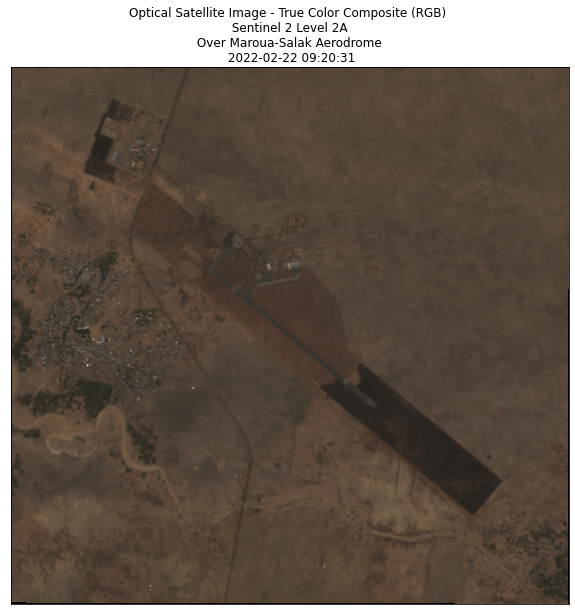

In [29]:
#Set band combinason
band_indices = [2, 1, 0]
#Plot Optical Satellite Image/True color composite
ep.plot_rgb(data.values,
            rgb=band_indices,
            title="Optical Satellite Image - True Color Composite (RGB) \n Sentinel 2 Level 2A \n Over Maroua-Salak Aerodrome \n 2022-02-22 09:20:31", 
            figsize=(10, 10),
           )
plt.show()

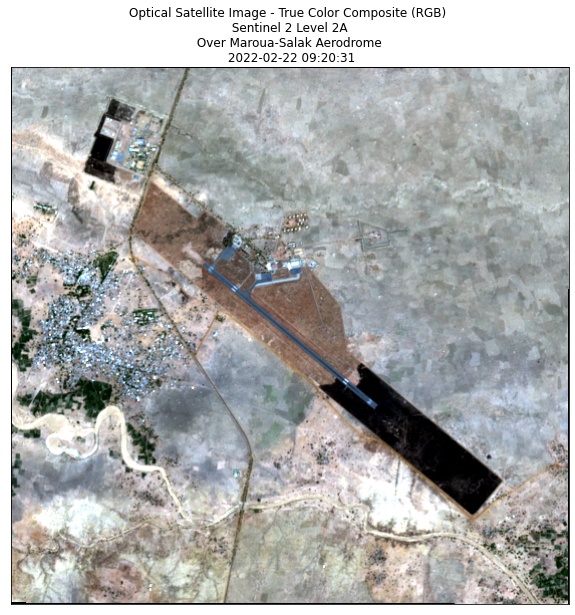

In [34]:
#Set band combinason
band_indices = [2, 1, 0]
#Plot Optical Satellite Image/True color composite
ep.plot_rgb(data.values,
            rgb=band_indices,
            title="Optical Satellite Image - True Color Composite (RGB) \n Sentinel 2 Level 2A \n Over Maroua-Salak Aerodrome \n 2022-02-22 09:20:31", 
            figsize=(10, 10),
            #Apply strecth function to enhance contrast, for better visualisation
            stretch=True)
plt.show()

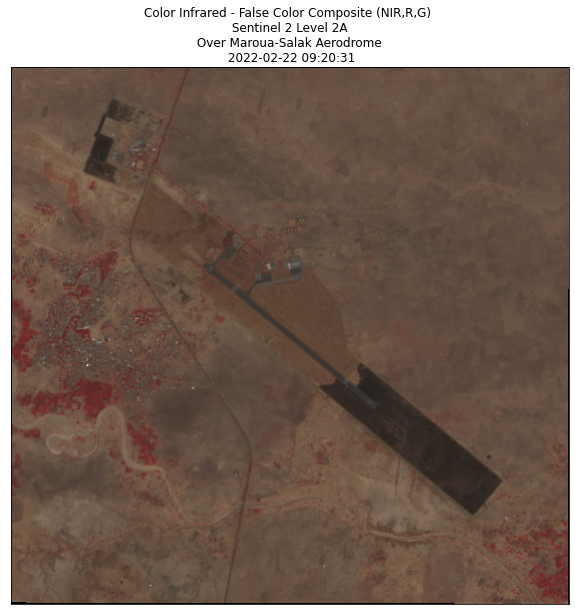

In [35]:
#Set band combinason
band_indices = [3, 2, 1]
#Plot Color Infrared Image/False color composite
ep.plot_rgb(data.values,
            rgb=band_indices,
            title="Color Infrared - False Color Composite (NIR,R,G) \n Sentinel 2 Level 2A \n Over Maroua-Salak Aerodrome \n 2022-02-22 09:20:31", 
            figsize=(10, 10),
           )
plt.show()

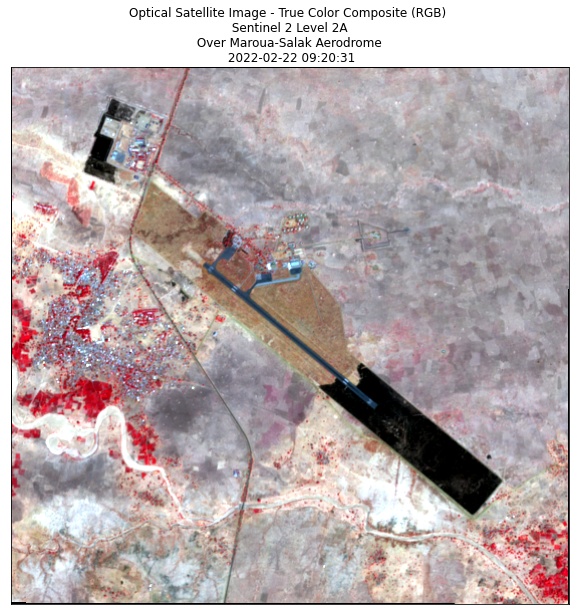

In [36]:
#Set band combinason
band_indices = [3, 2, 1]
#Plot Color Infrared Image/False color composite
ep.plot_rgb(data.values,
            rgb=band_indices,
            title="Optical Satellite Image - True Color Composite (RGB) \n Sentinel 2 Level 2A \n Over Maroua-Salak Aerodrome \n 2022-02-22 09:20:31", 
            figsize=(10, 10),
            #Apply strecth function to enhance contrast, for better visualisation
            stretch=True)
plt.show()